<a href="https://colab.research.google.com/github/lechemrc/DS-Unit-2-Applied-Modeling/blob/master/module3/assignment_applied_modeling_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science, Unit 2: Predictive Modeling

# Applied Modeling, Module 3

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [ ] Continue to iterate on your project: data cleaning, exploration, feature engineering, modeling.
- [ ] Make at least 1 partial dependence plot to explain your model.
- [ ] Share at least 1 visualization on Slack.

(If you have not yet completed an initial model yet for your portfolio project, then do today's assignment using your Tanzania Waterpumps model.)

## Stretch Goals
- [ ] Make multiple PDPs with 1 feature in isolation.
- [ ] Make multiple PDPs with 2 features in interaction. 
- [ ] Use Plotly to make a 3D PDP.
- [ ] Make PDPs with categorical feature(s). Use Ordinal Encoder, outside of a pipeline, to encode your data first. If there is a natural ordering, then take the time to encode it that way, instead of random integers. Then use the encoded data with pdpbox.I Get readable category names on your plot, instead of integer category codes.

## Links
- [Christoph Molnar: Interpretable Machine Learning — Partial Dependence Plots](https://christophm.github.io/interpretable-ml-book/pdp.html) + [animated explanation](https://twitter.com/ChristophMolnar/status/1066398522608635904)
- [Kaggle / Dan Becker: Machine Learning Explainability — Partial Dependence Plots](https://www.kaggle.com/dansbecker/partial-plots)
- [Plotly: 3D PDP example](https://plot.ly/scikit-learn/plot-partial-dependence/#partial-dependence-of-house-value-on-median-age-and-average-occupancy)

### Colab Setup

In [36]:
import os, sys
in_colab = 'google.colab' in sys.modules

# If you're in Colab...
if in_colab:
    # Pull files from Github repo
    os.chdir('/content')
    !git init .
    !git remote add origin https://github.com/LambdaSchool/DS-Unit-2-Applied-Modeling.git
    !git pull origin master
    
    # Install required python packages
    !pip install -r requirements.txt
    
    # Change into directory for module
    os.chdir('module1')

Reinitialized existing Git repository in /content/.git/
fatal: remote origin already exists.
From https://github.com/LambdaSchool/DS-Unit-2-Applied-Modeling
 * branch            master     -> FETCH_HEAD
Already up to date.


### Important Imports

In [0]:
# libraries and math functions
import pandas as pd
import numpy as np
import pandas_profiling
from scipy.io import arff # for loading .arff file
from scipy.stats import randint, uniform

# imports for pipeline and regression
import category_encoders as ce
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import validation_curve
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, accuracy_score, r2_score
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.utils.multiclass import unique_labels
from ipywidgets import interact, fixed
from xgboost import XGBRegressor, XGBClassifier
from pdpbox.pdp import pdp_isolate, pdp_plot, pdp_interact, pdp_interact_plot

# plotting
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

### Importing dataset

Dataset has largely been cleaned previously 

In [38]:
df = pd.read_csv('https://raw.githubusercontent.com/lechemrc/Datasets-to-ref/master/Autism%20Screening%20for%20Children/csv_result-Autism-Child-Data.csv', na_values='?')
print(df.shape)
df.head()

(292, 22)


,id,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,age,gender,ethnicity,jundice,austim,contry_of_res,used_app_before,result,age_desc,relation,Class/ASD
0,1,1,1,0,0,1,1,0,1,0,0,6.0,m,Others,no,no,Jordan,no,5,4-11 years,Parent,NO
1,2,1,1,0,0,1,1,0,1,0,0,6.0,m,Middle Eastern,no,no,Jordan,no,5,4-11 years,Parent,NO
2,3,1,1,0,0,0,1,1,1,0,0,6.0,m,NaN,no,no,Jordan,yes,5,4-11 years,NaN,NO
3,4,0,1,0,0,1,1,0,0,0,1,5.0,f,NaN,yes,no,Jordan,no,4,4-11 years,NaN,NO
4,5,1,1,1,1,1,1,1,1,1,1,5.0,m,Others,yes,no,United States,no,10,4-11 years,Parent,YES


### Data Wrangling

In [0]:
df = pd.read_csv('https://raw.githubusercontent.com/lechemrc/Datasets-to-ref/master/Autism%20Screening%20for%20Children/csv_result-Autism-Child-Data.csv', na_values='?')

def data_wrangle(df):
  ''' cleaning the data with one function'''

  # Cleaning column names
  df = df.rename(columns={'jundice':'born_jaundice', 
                          'austim':'family_pdd', 
                          'contry_of_res':'country', 
                          'used_app_before':'prior_screening'})

  # null values
  df = df.fillna(value='unspecified')

  # Dropping columns that don't contribute to model 
  # (as applied from permutation importnces in previous assignment)
  df = df.drop(['age_desc', 'result', 'born_jaundice', 
                'family_pdd', 'prior_screening'], axis=1)

  # Dropping id column to prevent obfuscation of data
  df = df.drop('id', axis=1)
  
  # Changing the country column values to 'other' if there are less
  # than 5 instances in the df
  frequencies = df['country'].value_counts()
  condition = frequencies <= 5
  mask = frequencies[condition].index
  mask_dict = dict.fromkeys(mask, 'other')

  df['country'] = df['country'].replace(mask_dict)

  # renaming values for clarity
  df['relation'] = df['relation'].replace(
      {'self':'Self', 
       'Health care professional':'Healthcare Professional', 
       'unspecified':'Unspecified'})
  
  df['ethnicity'] = df['ethnicity'].replace({'Pasifika':'Pacifica', 
                                           'Others':'unspecified'})

  return df

In [0]:
df = data_wrangle(df)

### Regression and Analysis

In [41]:
df['Class/ASD'].value_counts()

NO     151
YES    141
Name: Class/ASD, dtype: int64

In [42]:
df.columns

Index(['A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score',
       'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score', 'age', 'gender',
       'ethnicity', 'country', 'relation', 'Class/ASD'],
      dtype='object')

In [43]:
# Setting target and features
target = 'Class/ASD'

# Dropping 'result' and 'age' as they seem to be confounding and not helpful
features = df.columns.drop([target])

X = df[features]
y = df[target]

# Train / Test split
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42)

# Train / Val split 
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.25, 
    stratify=y_trainval, random_state=42)

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape 

((174, 15), (174,), (59, 15), (59,), (59, 15), (59,))

In [44]:
# To verify correct features
features

Index(['A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score',
       'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score', 'age', 'gender',
       'ethnicity', 'country', 'relation'],
      dtype='object')

#### Majority Class Accuracy

In [0]:
pd.options.display.float_format = None

In [46]:
y_train.value_counts(normalize=True)

NO     0.517241
YES    0.482759
Name: Class/ASD, dtype: float64

In [47]:
# Accuracy score using the majority class
majority_class = y_train.mode()[0]
y_pred = np.full_like(y_val, fill_value=majority_class)
accuracy_score(y_val, y_pred)

0.5084745762711864

#### Random Forest Classifier with Ordinal Encoding

In [48]:
random_forest = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
)

random_forest.fit(X_train, y_train)
y_pred = random_forest.predict(X_test)
print('Validation Accuracy:', random_forest.score(X_val, y_val), 
      '\nTest Accuracy:', random_forest.score(X_test, y_test))

Validation Accuracy: 0.8983050847457628 
Test Accuracy: 0.8813559322033898


In [66]:
xgboost = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(),
    XGBClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

xgboost.fit(X_train, y_train)
y_pred = xgboost.predict(X_test)
print('Validation Accuracy:', xgboost.score(X_val, y_val), 
      '\nTest Accuracy:', xgboost.score(X_test, y_test))

Validation Accuracy: 0.864406779661017 
Test Accuracy: 0.8813559322033898


#### Target Distribution plot

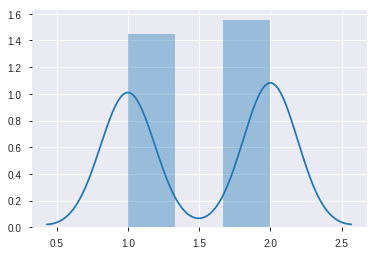

In [49]:
encoder = ce.OrdinalEncoder()
y_train_encoded = encoder.fit_transform(y_train)
sns.distplot(y_train_encoded);

### Partial Dependency Plot

In [69]:
X_train.columns

Index(['A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score',
       'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score', 'age', 'gender',
       'ethnicity', 'country', 'relation'],
      dtype='object')

In [0]:
plt.rcParams['figure.dpi'] = 72

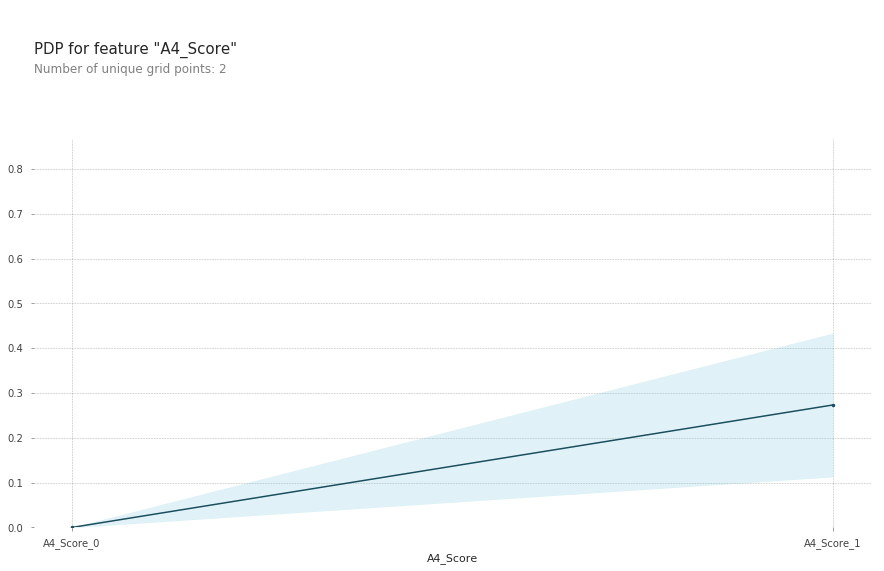

In [81]:
feature = 'A4_Score'

isolated = pdp_isolate(
    model = random_forest,
    dataset = X_val,
    model_features = X_val.columns,
    feature = feature
)

pdp_plot(isolated, feature_name=feature);

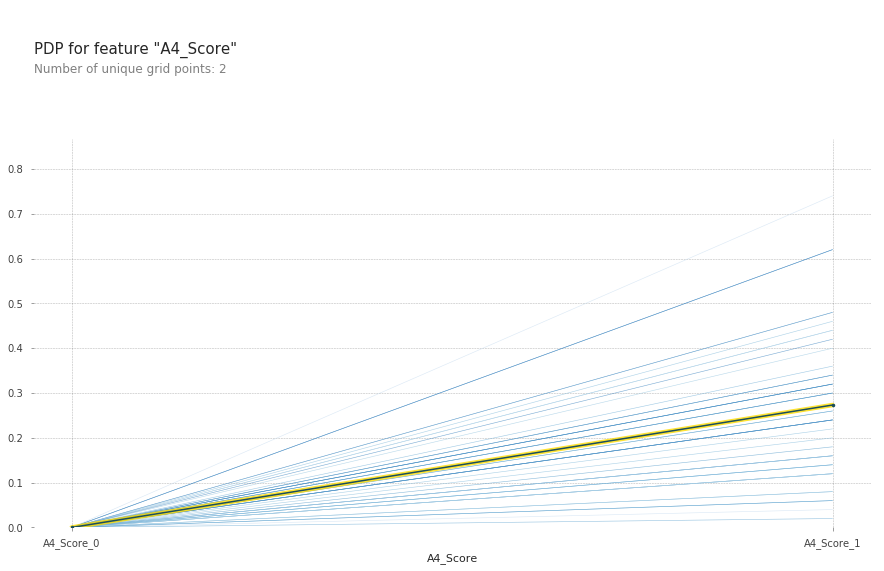

In [82]:
pdp_plot(isolated, feature_name=feature, plot_lines=True, frac_to_plot=50);

### 3D PDP Plot

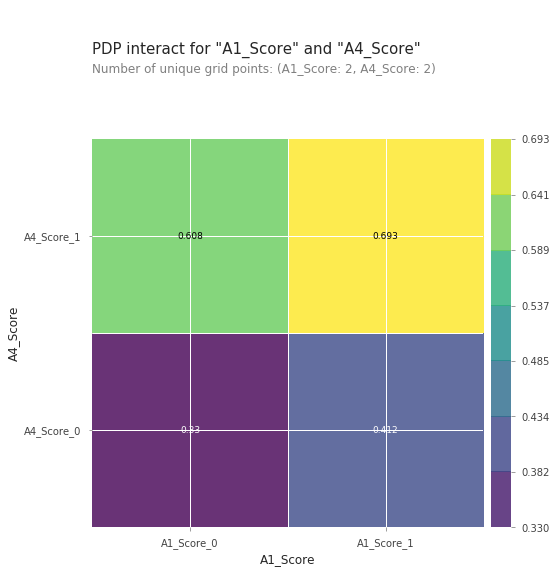

In [86]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

features = ['A1_Score', 'A4_Score']

interaction = pdp_interact(
    model=random_forest,
    dataset = X_val,
    model_features = X_val.columns,
    features=features
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=features);

Text(0.5, 1.0, 'Partial Dependence on Autism Diagnosis with A4 and A1 Scores')

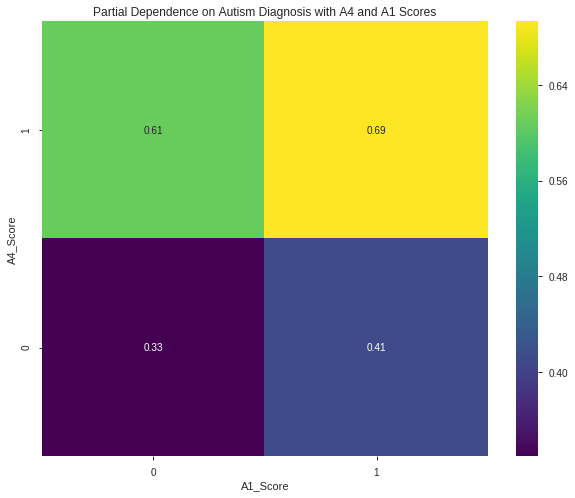

In [88]:
pdp = interaction.pdp.pivot_table(
    values='preds',
    columns=features[0],
    index=features[1]
)[::-1]

plt.figure(figsize=(10,8))
sns.heatmap(pdp, annot=True, fmt='.2f', cmap='viridis')
plt.title('Partial Dependence on Autism Diagnosis with A4 and A1 Scores')

In [89]:
import plotly.graph_objs as go

surface = go.Surface(x=pdp.columns, 
                     y=pdp.index, 
                     z=pdp.values)

fig = go.Figure(surface)
fig.show()

Again, binary features don't really give us much to go on here. It looks nice, but isn't a lot of information, really 